## Floroq-geneSet analysis

In [2]:
library(ggpubr)

Loading required package: ggplot2
Loading required package: magrittr


In [1]:
source('floroq_aaa_interaction.R')

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.8
v tidyr   0.8.2     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  match = col_logical(),
  searchTerm = col_character(),
  drugName = col_character(),
  geneID = col_integer(),
  geneName = col_character(),
  longGeneName = col_character(),
  interaction = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  match = col_character(),
  searchTerm = col_character(),
  drugName = col_character(),
  geneID = col_integer(),
  geneName = col_character(),
  longGeneName = co

In [4]:
drug_interactions  %>% 
    head(10)

floroq_interaction_genes <- unique(drug_interactions$geneName)
beta_interaction_genes <- unique(beta_lactams$geneName)

searchTerm,drugName,geneID,geneName,longGeneName,interaction
DB04576,FLEROXACIN,7153,TOP2A,DNA TOPOISOMERASE II ALPHA,[u'inhibitor']
DB04576,FLEROXACIN,7155,TOP2B,DNA TOPOISOMERASE II BETA,[u'inhibitor']
DB01165,OFLOXACIN,7153,TOP2A,DNA TOPOISOMERASE II ALPHA,[u'inhibitor']
DB01165,OFLOXACIN,6539,SLC6A12,SOLUTE CARRIER FAMILY 6 MEMBER 12,[u'inhibitor']
DB01165,OFLOXACIN,2936,GSR,GLUTATHIONE-DISULFIDE REDUCTASE,[]
DB01165,OFLOXACIN,4363,ABCC1,ATP BINDING CASSETTE SUBFAMILY C MEMBER 1,[]
DB01165,OFLOXACIN,3558,IL2,INTERLEUKIN 2,[]
DB01165,OFLOXACIN,3553,IL1B,INTERLEUKIN 1 BETA,[]
DB01165,OFLOXACIN,6529,SLC6A1,SOLUTE CARRIER FAMILY 6 MEMBER 1,[u'inhibitor']
DB00978,LOMEFLOXACIN,7153,TOP2A,DNA TOPOISOMERASE II ALPHA,[u'inhibitor']


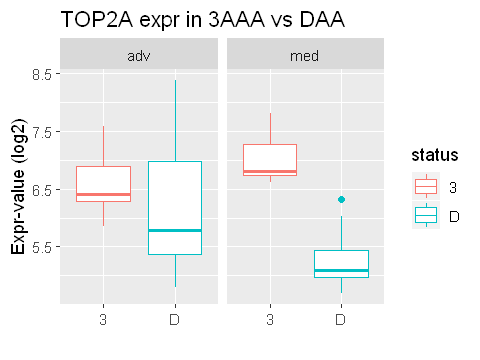

In [5]:
options(repr.plot.width=4, repr.plot.height=3)

df_long  %>% 
    filter(geneName == 'TOP2A')  %>%
    ggplot(aes(x = status, y = value, col = status)) +
    geom_boxplot() + 
    facet_wrap(~tissue) + 
    labs(title = 'TOP2A expr in 3AAA vs DAA',
         x = '', 
         y = 'Expr-value (log2)')

In [80]:
library(ggridges)

Run differential expression for the floroquinolone and betalactam data-sets. 

In [73]:
t.floroq_med <- df_long %>%
    filter(tissue == 'med')  %>% 
    filter(geneName %in% unique(drug_interactions$geneName))  %>% 
    group_by(geneName) %>%
    do(tidy(t.test(.$value ~ .$status)))  %>%
    ungroup()  %>% 
    mutate(fdr = p.adjust(p.value, method = "fdr"))

t.beta_med <- df_long %>%
    filter(tissue == 'med')  %>% 
    filter(geneName %in% unique(beta_interaction_genes))  %>% 
    group_by(geneName) %>%
    do(tidy(t.test(.$value ~ .$status)))  %>% 
    ungroup()  %>% 
    mutate(fdr = p.adjust(p.value, method = "fdr"))




In [81]:
p_floro <- df_long  %>% 
    filter(geneName %in% floroq_interaction_genes, tissue == 'med')  %>%
    left_join(t.floroq_med, by = 'geneName')  %>%
    ggplot(aes(x=value, y = geneName, fill = status)) +
    geom_density_ridges(aes(alpha = fdr < 0.05)) +
    theme_pubclean() +
    labs(
        subtitle = 'Floroquinolones', 
         y ='',
         x = 'Log2-expression value')#caption = 'Drug-gene-interactions are retrieved from DGIdb') +
   
p_beta <- df_long  %>% 
    filter(geneName %in% beta_interaction_genes, tissue == 'med')  %>%
    left_join(t.beta_med, by = 'geneName')  %>%
    ggplot(aes(x=value, y = geneName, fill = status)) +
    geom_density_ridges(aes(alpha = fdr < 0.05)) +
    theme_pubclean() +
    labs(subtitle = 'Beta-lactams', 
         y ='',
         x = 'Log2-expression value',
         caption = 'Drug-gene-interactions are retrieved from DGIdb')

Warning message:
"Using alpha for a discrete variable is not advised."Picking joint bandwidth of 0.208
Warning message:
"Using alpha for a discrete variable is not advised."Picking joint bandwidth of 0.208
Warning message:
"Using alpha for a discrete variable is not advised."Picking joint bandwidth of 0.21


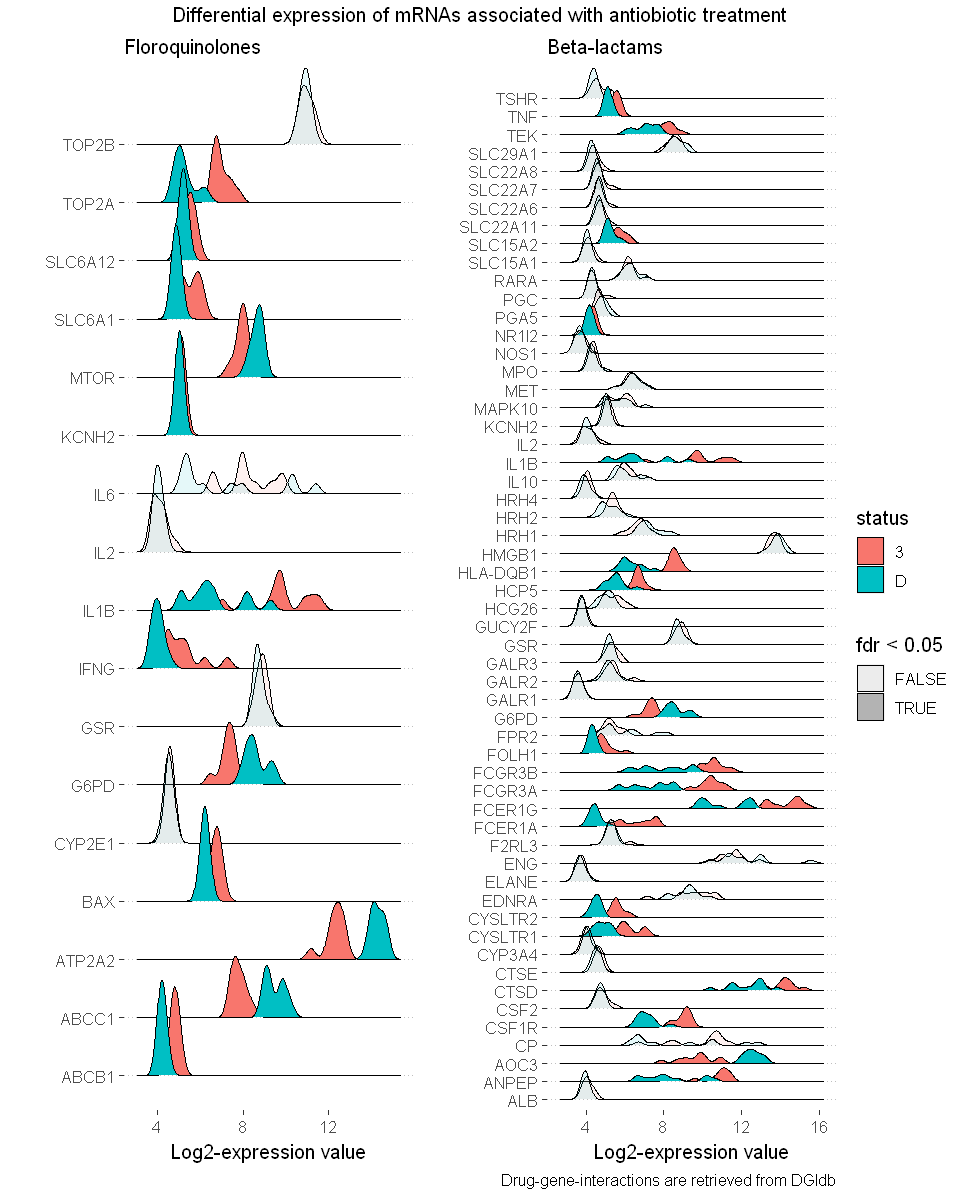

In [82]:
options(repr.plot.width=8, repr.plot.height=10)
floro_beta_dgidb <- ggarrange(p_floro, p_beta, align = 'hv', legend = 'right', common.legend = TRUE)
annotate_figure(floro_beta_dgidb, 
                top = 'Differential expression of mRNAs associated with antiobiotic treatment')

In [72]:
p1_med <- t.floroq_med  %>% 
    ungroup()  %>% 
    mutate(geneName = fct_reorder(geneName, fdr))  %>% 
    ggplot(aes(x = geneName, y = estimate, col = geneName)) +
        geom_errorbar(aes(x=geneName, ymin=conf.low, ymax=conf.high, alpha = (1-fdr) ))+
    coord_flip() +    
    geom_hline(yintercept = 0.00, linetype ='dotted',
    color = "black", size=0.5) +
    guides(col = FALSE, alpha = FALSE) +
    annotate(geom="text", x=17, y=-1.5, label="More in DA",
              color="black", size = 2.5)+
        annotate(geom="text", x=17, y=1.5, label="More in 3A",
              color="black", size = 2.5) +
    labs(title = 'Difference in mean-expr',
         y = 'Estimate (log2)',
         x = '') 

p2_med <- t.floroq_med  %>% 
    ungroup()  %>% 
    mutate(geneName = fct_reorder(geneName, fdr))  %>% 
    ggplot(aes(x = geneName, y = fdr, fill = geneName)) + 
    geom_col() + 
    coord_flip() + 
    geom_hline(yintercept = 0.05, linetype ='dotted',
                color = "black", size=0.5) +
    guides(fill = FALSE) + 
    labs(title = 'FDR q-value',
         y = 'q-value')

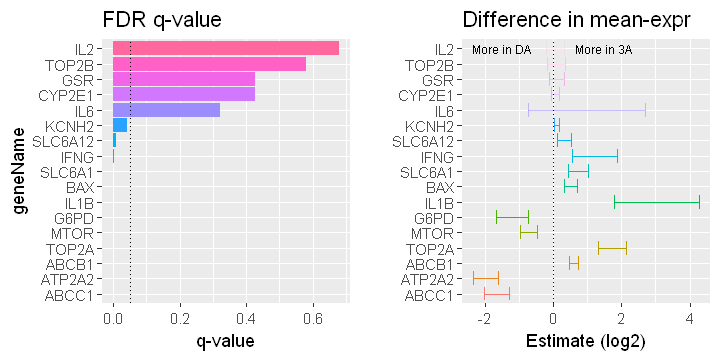

In [83]:
options(repr.plot.width=6, repr.plot.height=3)
ggpubr::ggarrange(p2_med,p1_med)


## Gene Set Enrichment analysis for floroq-drug-gene interactions

First, the constructed ranked gene list by t.-test estimate is gathered from the floroq_aaa_interaction.R source file. 

In [87]:
which(t.ranked_diff_genes_med$geneName == 'MMP12')   

[1] 1

Define function that takes a rankedList of genes and a geneSet and returns the position of the genes in the gene set in the rankedList

In [88]:
f.gsea <- function(rankedList, geneSet) {
    a = vector()
    for(key in geneSet){
        a <- append(a, which(rankedList == key))
    }
    gsea_df <- as.data.frame(cbind(a, geneSet))  %>% 
    mutate(a = as.numeric(as.character(a)))
    return(gsea_df)
}

In [89]:
floro_a <- f.gsea(t.ranked_diff_genes_med$geneName, unique(drug_interactions$geneName))
beta_a <- f.gsea(t.ranked_diff_genes_med$geneName, unique((beta_interaction_genes)))

Warning message in cbind(a, geneSet):
"number of rows of result is not a multiple of vector length (arg 1)"

## Floroq

In [91]:
p_gsea1_floro <- floro_a  %>% 
    ggplot(aes(x = a, y = 1)) +
    geom_point(size = 0.5)+
    geom_errorbar(aes(x = a, ymin = 0.5, ymax = 1.5)) +
    xlim(1,dim(t.ranked_diff_genes_med)[1])+
    theme_bw() + 
    labs( 
         x = 'Position in the Ranked List of Genes',
         y = '')+
    remove_y_axes

Ns <- length(unique(drug_interactions$geneName))
N <- dim(t.ranked_diff_genes_med)[1]
Xmi <- -sqrt(Ns/(N-Ns))
Xpl <- sqrt((N-Ns)/Ns)

# Calculate enrichment score. 
# All places where gene is not in gene set, add (Xmi)
# for all where gene is in gene set add Xpl. 

enrichment_score <- rep(Xmi, dim(t.ranked_diff_genes_med)[1])
for(i in floro_a$a){
    enrichment_score[i] <- Xpl
}

# compute the cumulative sum
enrich_cum_score <- cumsum(enrichment_score)
df_gsea <- as.data.frame(cbind(enrich_cum_score, 1:length(enrich_cum_score)))

p_gsea2_floro <-  df_gsea  %>% 
    ggplot(aes(x=V2, y=enrich_cum_score)) +  
    geom_line(col = 'black') +
    ylim(-300,300) +
    geom_hline(yintercept = 0.00, linetype ='dotted',
                color = "blue", size=0.5) +
    xlim(1,dim(t.ranked_diff_genes_med)[1])+
    theme_bw() + 
    labs(title = 'Floroquinolone geneSet from DGIdb (n=17)', 
         x = 'Position in the Ranked List of Genes',
         y = 'Enrichment score (ES)') +
    remove_x_axes +
    remove_y_axes



## Beta lactams

In [92]:
p_gsea1_beta <- beta_a  %>% 
    ggplot(aes(x = a, y = 1)) +
    geom_point(size = 0.5)+
    geom_errorbar(aes(x = a, ymin = 0.5, ymax = 1.5)) +
    xlim(1,dim(t.ranked_diff_genes_med)[1])+
    theme_bw() + 
    labs( 
         x = 'Position in the Ranked List of Genes',
         y = '')+
    remove_y_axes

Ns <- length(unique(beta_interaction_genes)) -1
N <- dim(t.ranked_diff_genes_med)[1]
Xmi <- -sqrt(Ns/(N-Ns))
Xpl <- sqrt((N-Ns)/Ns)

# Calculate enrichment score. 
# All places where gene is not in gene set, add (Xmi)
# for all where gene is in gene set add Xpl. 

enrichment_score <- rep(Xmi, dim(t.ranked_diff_genes_med)[1])
for(i in beta_a$a){
    enrichment_score[i] <- Xpl
}

# compute the cumulative sum
enrich_cum_score <- cumsum(enrichment_score)
df_gsea <- as.data.frame(cbind(enrich_cum_score, 1:length(enrich_cum_score)))

p_gsea2_beta <-  df_gsea  %>% 
    ggplot(aes(x=V2, y=enrich_cum_score)) +  
    geom_line(col = 'black') +
    ylim(-300,300) +
    geom_hline(yintercept = 0.00, linetype ='dotted',
                color = "blue", size=0.5) +
    xlim(1,dim(t.ranked_diff_genes_med)[1])+
    theme_bw() + 
    labs(title = 'Beta-lactams geneSet from DGIdb (n=56)', 
         x = 'Position in the Ranked List of Genes',
         y = 'Enrichment score (ES)') +
    remove_x_axes +
    remove_y_axes


In [93]:
g2 <- ggarrange(p_gsea2_floro, p_gsea1_floro, nrow = 2)
g1 <- ggarrange(p_gsea2_beta, p_gsea1_beta, nrow = 2)

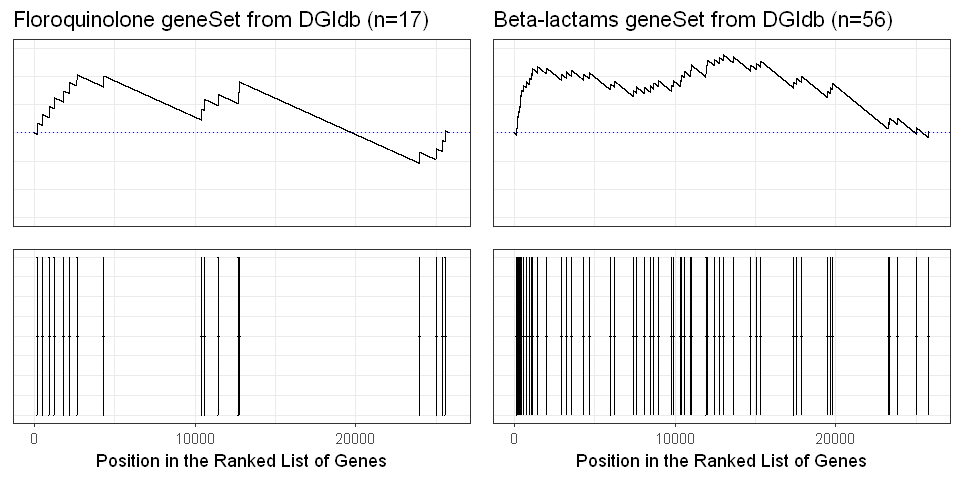

In [94]:
options(repr.plot.width=8, repr.plot.height=4)
ggarrange(g2,g1)

In [97]:
library(gage)

In [160]:
t.test(beta_a$a, alternative ='greater')


	One Sample t-test

data:  beta_a$a
t = 9.2429, df = 56, p-value = 3.66e-13
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 7607.309      Inf
sample estimates:
mean of x 
 9287.982 


In [178]:
t.beta_med$p.value  %>% psych::geometric.mean()

[1] 0.01203339

In [177]:
t.beta_med <- df_long %>%
    filter(tissue == 'med')  %>% 
    filter(geneName %in% unique(beta_interaction_genes))  %>% 
    group_by(geneName) %>%
    do(tidy(t.test(.$value ~ .$status, alternative = 'two.sided', var.equal = FALSE)))  %>% 
    ungroup()  %>% 
    mutate(fdr = p.adjust(p.value, method = "fdr"))


In [192]:
ks.test(beta_a$a, y = 'pbinom', size = dim(df)[1], prob = 0.5)


Warning message in ks.test(beta_a$a, y = "pbinom", size = dim(df)[1], prob = 0.5):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  beta_a$a
D = 0.71022, p-value < 2.2e-16
alternative hypothesis: two-sided


In [186]:
?ks.test()

In [105]:
df_gs <- df  %>% select(geneName, matches('med'))  %>% as.data.frame()
rownames(df_gs) <- df$geneName
df_gs[,1] <- NULL

In [181]:
gage(df_gs, gsets, ref = ref, samp = samp, compare = 'as.group', rank.test = TRUE)

$greater
      p.geomean stat.mean      p.val      q.val set.size       exp1
[1,] 0.00775719 2.4584304 0.00775719 0.01551438       56 0.00775719
[2,] 0.17193333 0.9616638 0.17193333 0.17193333       17 0.17193333

$less
     p.geomean stat.mean     p.val     q.val set.size      exp1
[1,] 0.9922428 2.4584304 0.9922428 0.9922428       56 0.9922428
[2,] 0.8280667 0.9616638 0.8280667 0.9922428       17 0.8280667

$stats
     stat.mean      exp1
[1,] 2.4584304 2.4584304
[2,] 0.9616638 0.9616638

In [120]:
gsets <- list(unique(beta_interaction_genes), unique(drug_interactions$geneName))

In [125]:
colnames(df_gs)

[1] "3A003_TH_med" "3A004_TH_med" "3A005_TH_med" "3A012_TH_med" "3A013_TH_med"
 [6] "3A027_TH_med" "3A031_TH_med" "3A042_TH_med" "3A057_TH_med" "3A059_TH_med"
[11] "DAA03_TH_med" "DAA05_TH_med" "DAA10_TH_med" "DAA12_TH_med" "DAA13_TH_med"
[16] "DAA15_TH_med" "DAA17_TH_med" "DAA20_TH_med" "DAA24_TH_med" "DAA26_TH_med"
[21] "DAA27_TH_med"

In [134]:
ref <- grep('DAA', colnames(df_gs))
samp <- grep('3A', colnames(df_gs))

In [2]:
dim(features)


ERROR: Error in eval(expr, envir, enclos): object 'features' not found


In [ ]:
beta